- 대출요청에 대해, 익명화되었지만 전처리 방향을 구상해봄
- tree기반의 모형을 쓸 것이라 scaling은 고민하지 않음
- 범주형이 모두 숫자로 인코딩 된 것으로 보임 -> 범주형을 감지해서 원핫을 시도
- 변수 선택의 방법으로 Kolmogorov를 생각해봄

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "../take-home-interview/"

In [3]:
app = pd.read_csv(data_path + "loan_application.csv")

In [4]:
df = app[app.target.notna()]
df_test = app[app.target.isna()].drop('target', axis=1)

# del app

### 범주형 자료

In [5]:
feature_cols = [col for col in df.columns if col.startswith("col")]

In [6]:
print(f"현재 피쳐 수: {len(feature_cols)}")

현재 피쳐 수: 120


In [7]:
## 테스트에서 범주가 1가지밖에 없는 케이스는 다 제거
unique_value_count_test = pd.Series({col:df_test[col].nunique() for col in feature_cols}).sort_values()

unique_columns = unique_value_count_test[unique_value_count_test == 1].index

feature_cols = [col for col in feature_cols if col not in set(unique_columns)]

df = df.drop(unique_columns, axis=1)
df_test = df_test.drop(unique_columns, axis=1)

In [8]:
## 유니크한 값의 수가 적은 케이스는 범주로 보임 -> 원핫 인코딩이 필요한지에 대해 고민
unique_value_count_test = pd.Series({col:df_test[col].nunique() for col in feature_cols}).sort_values()

In [9]:
print(f"현재 피쳐 수: {len(feature_cols)}")

현재 피쳐 수: 109


<AxesSubplot:>

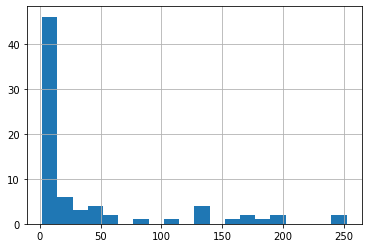

In [10]:
unique_value_count_test[unique_value_count_test < 500].hist(bins=20)

<AxesSubplot:>

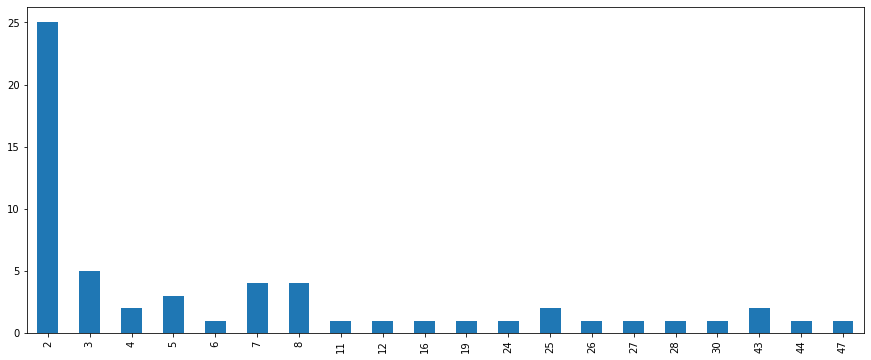

In [11]:
plt.figure(figsize=(15,6))
unique_value_count_test.value_counts().sort_index().head(20).plot.bar()

**범주형 자료는 원핫을 해야할까**

/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/dane.ahn/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


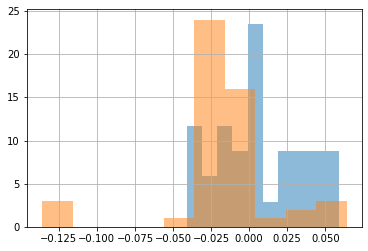

In [12]:
## 이거로는 파악이 잘 안되는 것 같다
res = []
for col in unique_value_count_test[(unique_value_count_test>2)&(unique_value_count_test<50)].index:
#     print(f"{col}: {df[[col, 'target']].corr().target.values[0]:.4f}")
    res.append([col, df[[col, 'target']].corr(method='kendall').target.values[0]])

pd.DataFrame(res, columns=['col', 'corr'])['corr'].hist(density=True, alpha=0.5)

res = []
for col in unique_value_count_test[(unique_value_count_test>50)&(unique_value_count_test<np.inf)].index:
#     print(f"{col}: {df[[col, 'target']].corr().target.values[0]:.4f}")
    res.append([col, df[[col, 'target']].corr(method='kendall').target.values[0]])

pd.DataFrame(res, columns=['col', 'corr'])['corr'].hist(density=True, alpha=0.5)

plt.show()

In [106]:
## 켄달
res = []
for col in unique_value_count_test[unique_value_count_test>2].index:
    res.append([col, df[[col, 'target']].corr(method='kendall').target.values[0], df[col].nunique()])

cor_df = pd.DataFrame(res, columns=['col', 'corr', 'nunique'])

plt.scatter(cor_df['corr'], cor_df['nunique'])
plt.yscale('log')
plt.show()

KeyError: "['col_100'] not in index"

In [17]:
## 1, 2, 3, .., k와 같은 형식의 칼럼은 더미 같다는 아이디어
res = []
for col in feature_cols:
    col_unique_values = df[col].dropna().unique().tolist()
    
    if (len(col_unique_values) <= 2):
        continue
    
    s1 = set(col_unique_values)
    s2 = set(range(len(s1)))
    s3 = set(range(1, len(s1)+1))
    
    test_only_value_count = len(set(df_test[col].dropna().unique()) - set(df[col].dropna().unique()))
    res.append([
        col, len(col_unique_values), (len(s1&s2) / len(s1|s2)), (len(s1&s3) / len(s1|s3)), test_only_value_count
    ])


col_is_cate = pd.DataFrame(res, columns=['col', 'nunique', 'jaccard_sim1', 'jaccard_sim2', "test_only"])

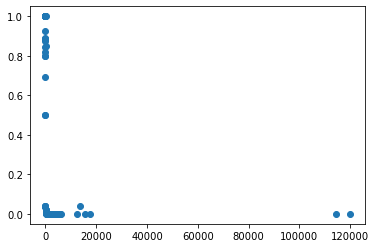

In [19]:
plt.scatter(col_is_cate['nunique'], col_is_cate['jaccard_sim1'])

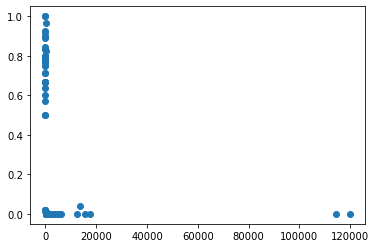

In [20]:
plt.scatter(col_is_cate['nunique'], col_is_cate['jaccard_sim2'])

In [21]:
col_cate = col_is_cate[(col_is_cate.jaccard_sim1 >= 0.5)|((col_is_cate.jaccard_sim2 >= 0.5))]
col_cate = col_cate[col_cate['nunique'] <= 50]
col_cate = col_cate[col_cate.test_only == 0]
col_cate.sort_values('nunique')

,col,nunique,jacard_sim1,jacard_sim2,test_only
12,col_20,3,0.500000,1.000000,0
72,col_107,3,1.000000,0.500000,0
84,col_121,3,1.000000,0.500000,0
82,col_119,4,1.000000,0.600000,0
66,col_100,5,1.000000,0.666667,0
81,col_118,5,1.000000,0.666667,0
75,col_112,5,1.000000,0.666667,0
77,col_114,6,1.000000,0.714286,0
76,col_113,6,1.000000,0.714286,0
79,col_116,7,1.000000,0.750000,0


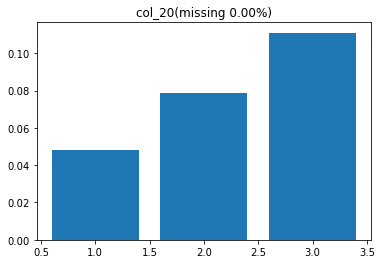

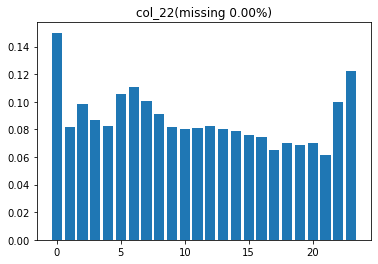

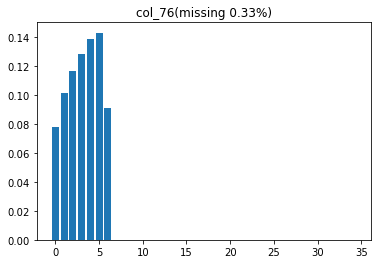

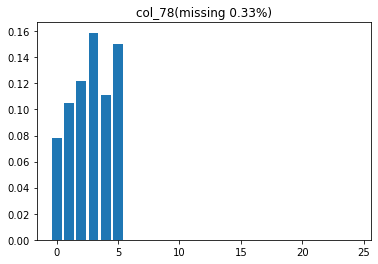

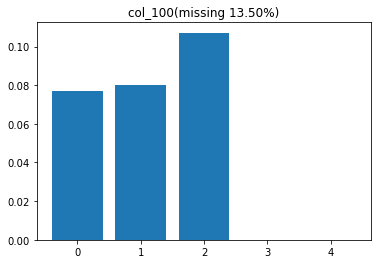

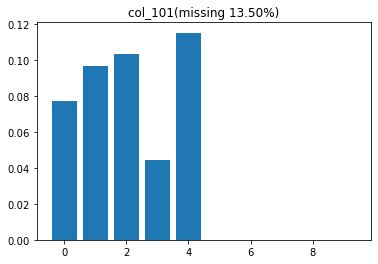

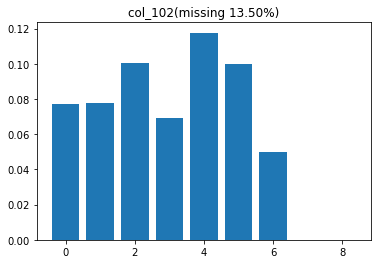

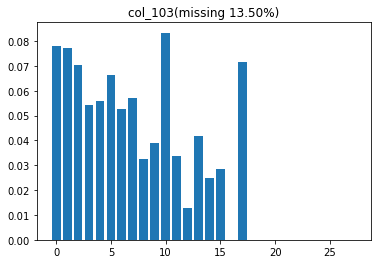

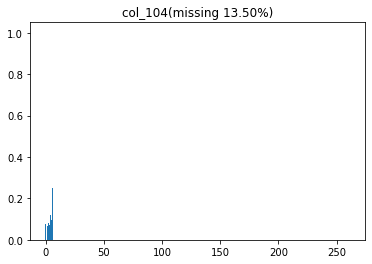

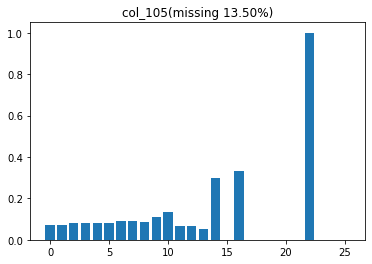

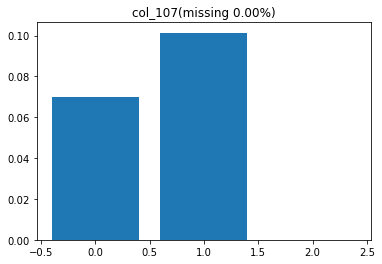

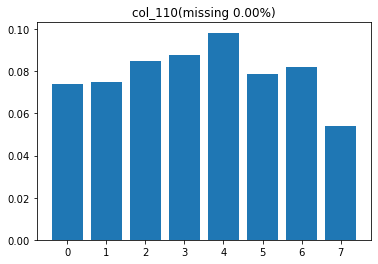

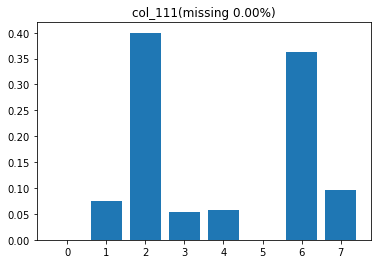

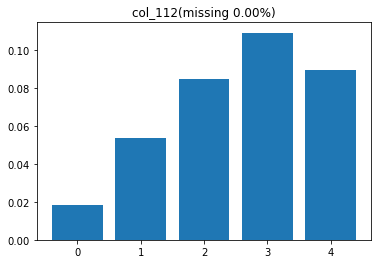

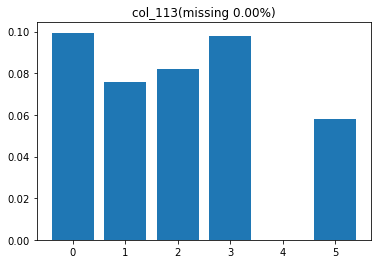

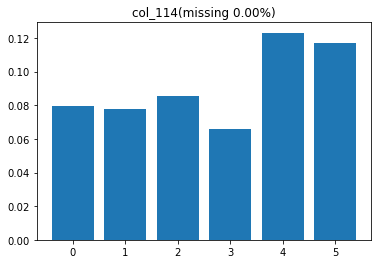

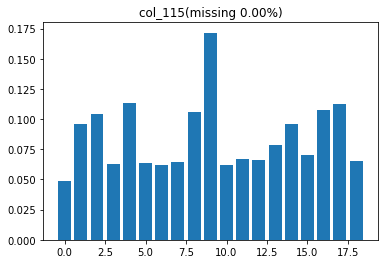

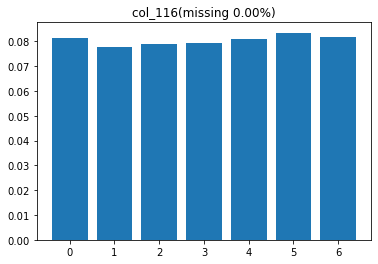

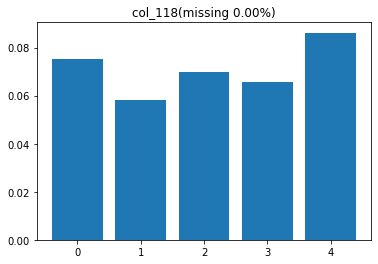

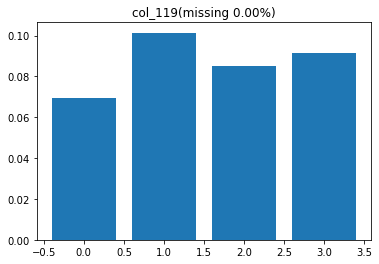

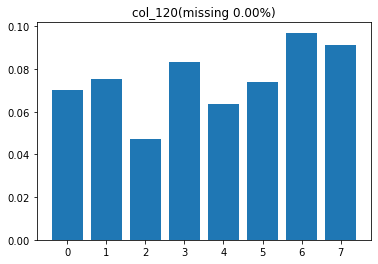

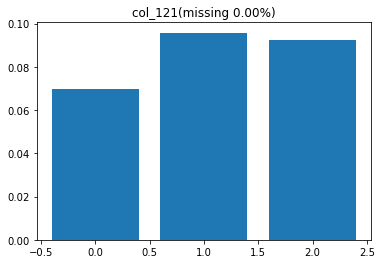

In [22]:
## 일반적으로 선형적이지 않음을 확인 -> 원핫 인코딩 필요 
for col in col_cate.col:
    res = []
    for col_value, group in df.groupby(col):
        res.append([col_value, group.target.mean()])

    col_value_target_mean = pd.DataFrame(res, columns=['col_value', 'target_mean'])
    missng_ratio = df[col].isna().mean()

    plt.bar(col_value_target_mean.col_value, col_value_target_mean.target_mean)
    plt.title(f"{col}(missing {missng_ratio*100:.2f}%)")
    plt.show()

In [42]:
for col in col_cate.col:
    col_val_cnt = df[col].value_counts()

    minor_values = col_val_cnt[col_val_cnt<=10].index
    
    val_etc = df[col].min() - 1
    for minor_value in minor_values:
        df[col].replace({minor_value:val_etc})
    if len(minor_values) > 1:
        print(f"{len(minor_values)}가지 카테고리 제거 -> {col_val_cnt[col_val_cnt<=10].sum()}개의 관측치를 예외 케이스로 변경")
    
    dummy_na = df[col].isna().sum() > 0
    temp_dummy = pd.get_dummies(df[col], drop_first=True, prefix=col, dummy_na=dummy_na)
    temp_dummy = temp_dummy.astype(np.int8)
    
    df = df.drop(col, axis=1)
    df = pd.concat([df, temp_dummy], axis=1)

3가지 카테고리 제거 -> 3개의 관측치를 예외 케이스로 변경
3가지 카테고리 제거 -> 5개의 관측치를 예외 케이스로 변경
2가지 카테고리 제거 -> 10개의 관측치를 예외 케이스로 변경
4가지 카테고리 제거 -> 20개의 관측치를 예외 케이스로 변경
3가지 카테고리 제거 -> 17개의 관측치를 예외 케이스로 변경
6가지 카테고리 제거 -> 13개의 관측치를 예외 케이스로 변경
4가지 카테고리 제거 -> 16개의 관측치를 예외 케이스로 변경
11가지 카테고리 제거 -> 39개의 관측치를 예외 케이스로 변경
2가지 카테고리 제거 -> 15개의 관측치를 예외 케이스로 변경


In [43]:
feature_cols = [col for col in df.columns if col.startswith("col")]

print(f"현재 피쳐 수: {len(feature_cols)}")

현재 피쳐 수: 284


**케이스가 너무 적은 것은 룰 베이스로 제외**

In [107]:
unique_value_count_test = pd.Series({col:df_test[col].nunique() for col in feature_cols}).sort_values()

KeyError: 'col_20_2'

In [47]:
## test에서 값이 너무 희소하고 (0.1%미만)
## 희소한 경우 train에서 target 값이 unique한 관측치들은 룰베이스로 제외
## missing도 캐치
test_n = len(df_test)
for col in unique_value_count_test[unique_value_count_test == 2].index:
    small_value_count = df_test[col].value_counts().min()
    small_value_ratio = small_value_count/test_n

    if small_value_ratio < 0.001:
        print(col)
        count_df = pd.concat([
            df[col].fillna("null").value_counts(), 
            df_test[col].value_counts()
        ], axis=1).sort_index()

        count_df.columns = ['train', 'test']
        display(count_df)
        
        small_target_dist = (
            df.loc[df[col]==count_df.test.idxmin(), 'target']
            .value_counts().reset_index()
        )
        small_target_dist.columns = ['target', 'count']
        small_target_dist = small_target_dist.assign(ratio=small_target_dist['count'] / small_target_dist['count'].sum())
        
        
        display(small_target_dist)

col_13


,train,test
0,1,1
1,307510,48743


,target,count,ratio
0,0.0,1,1.0


col_85


,train,test
0,307452,48742
1,59,2


,target,count,ratio
0,0.0,56,0.949153
1,1.0,3,0.050847


col_82


,train,test
0,307486,48739
1,25,5


,target,count,ratio
0,0.0,25,1.0


In [48]:
## test에서 값이 너무 희소하고 (0.1%미만)
## 희소한 경우 train에서 target 값이 unique한 관측치들은 룰베이스로 제외
## rule_predict의 key는 rule base로 제외할 칼럼
## value는 다시 dict로, minor_value를 가진 경우 target으로 예측
## 해당 칼럼은 처리한 뒤 지우자
rule_predict = {}
for col in unique_value_count_test[unique_value_count_test == 2].index:
    
    small_value_ratio = df_test[col].value_counts(normalize=True).min()
    if small_value_ratio < 0.001:
    
        col_minor_value = df_test[col].value_counts().idxmin()
        col_minor_target_dist = df.loc[df[col]==col_minor_value, 'target'].value_counts()
        if len(col_minor_target_dist) == 1:
            
            rule_predict[col] = {
                "minor_value":col_minor_value,
                "target":col_minor_target_dist.index[0]
            }

rule_predict

feature_cols = [col for col in feature_cols if col not in rule_predict]
df = df.drop(rule_predict.keys(), axis=1)

print(f"현재 피쳐 수: {len(feature_cols)}")

현재 피쳐 수: 282


### Missing

In [52]:
df.isna().mean().nlargest(10)

col_36    0.698723
col_50    0.698723
col_64    0.698723
col_44    0.694330
col_58    0.694330
col_72    0.694330
col_42    0.683550
col_56    0.683550
col_70    0.683550
col_40    0.678486
dtype: float64

In [58]:
missing_columns = [col for col in df.columns if 'nan' in col]
pd.Series({col:(df[col]==1).mean() for col in missing_columns}).sort_values()

col_76_nan     0.003320
col_78_nan     0.003320
col_100_nan    0.135016
col_101_nan    0.135016
col_102_nan    0.135016
col_103_nan    0.135016
col_104_nan    0.135016
col_105_nan    0.135016
dtype: float64

In [53]:
df_test.isna().mean().nlargest(10)

col_36    0.687161
col_50    0.687161
col_64    0.687161
col_44    0.684125
col_58    0.684125
col_72    0.684125
col_42    0.672493
col_56    0.672493
col_70    0.672493
col_40    0.666051
dtype: float64

### 변수 선택
- Kolmogofov를 이용해 target이 0일 때와 1일 때 x의 분포 사이에 차이가 있는지 검토

In [59]:
from scipy import stats

In [60]:
df_true = df.loc[df.target==1]
df_false = df.loc[df.target==0]

In [61]:
feature_cols = [col for col in df.columns if col.startswith("col")]

In [62]:
from tqdm import tqdm

In [63]:
ps = []
for col in tqdm(feature_cols):
    statistics, p = stats.ks_2samp(df_true[col], df_false[col])
    ps.append([col, p])

100%|██████████| 282/282 [00:10<00:00, 26.25it/s]


In [64]:
p_df = pd.DataFrame(ps, columns=['col_name', 'p_value'])

<AxesSubplot:>

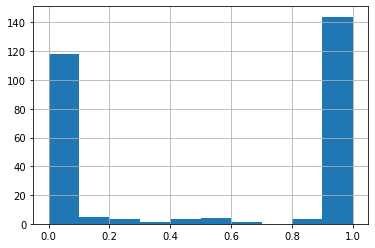

In [65]:
p_df.p_value.hist()

In [66]:
p_df.nsmallest(10, 'p_value').col_name

25        col_30
26        col_31
6          col_8
227    col_111_7
72        col_79
212    col_107_1
4          col_6
228    col_112_1
24        col_29
7          col_9
Name: col_name, dtype: object

In [67]:
selected_cols = p_df.nsmallest(10, 'p_value').col_name.tolist()

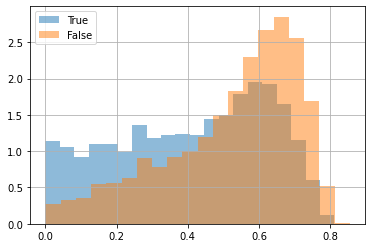

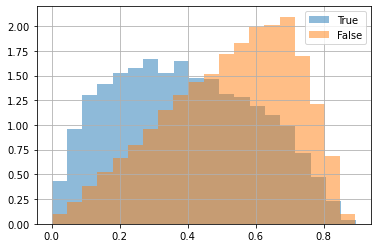

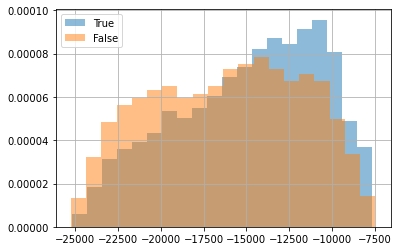

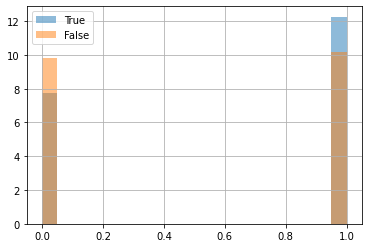

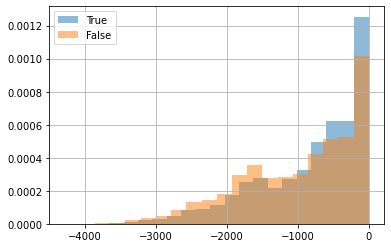

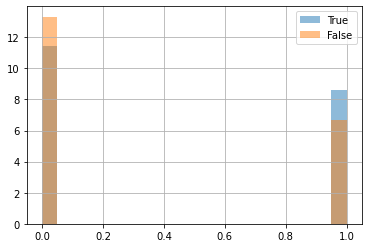

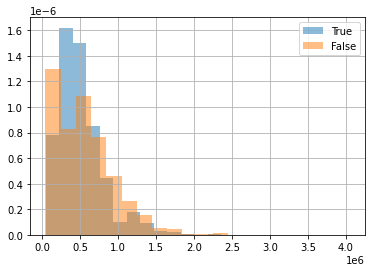

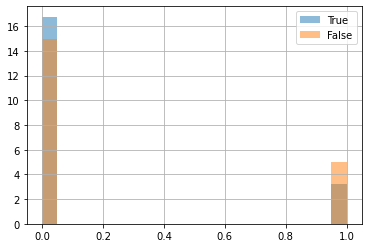

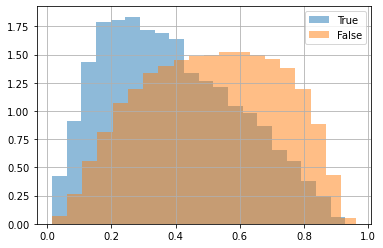

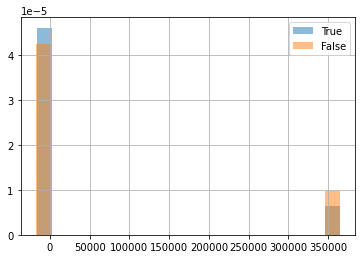

In [68]:
leg = []
for col in selected_cols:
    df_true[col].hist(alpha=0.5, density=True, bins=20)
    df_false[col].hist(alpha=0.5, density=True, bins=20)
    plt.legend([True, False])
    plt.show()

In [69]:
not_selected_cols = p_df.nlargest(10, 'p_value').col_name.tolist()

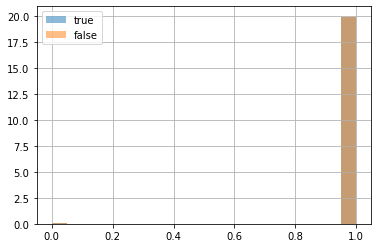

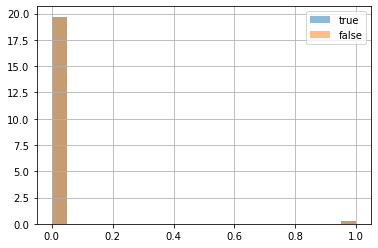

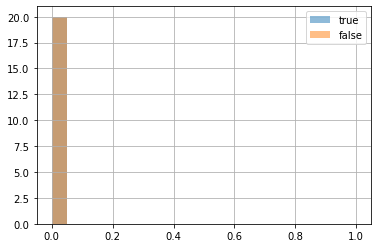

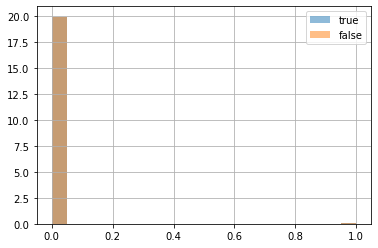

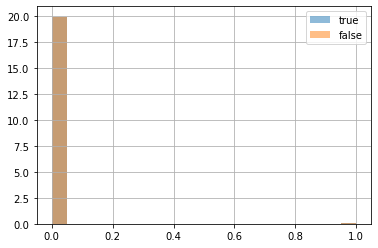

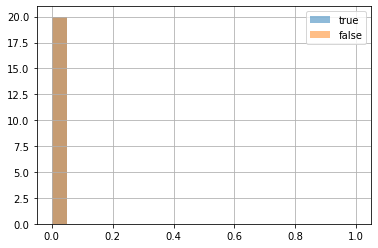

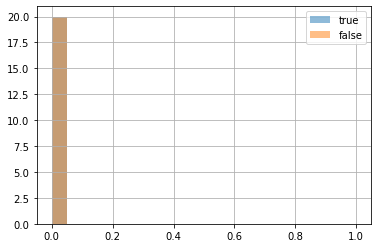

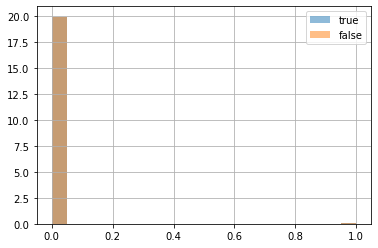

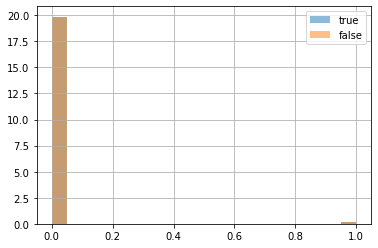

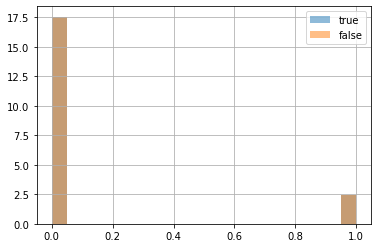

In [72]:
for col in not_selected_cols:
    df_true[col].hist(alpha=0.5, density=True, bins=20)
    df_false[col].hist(alpha=0.5, density=True, bins=20)
    plt.legend(['true', 'false'])
    plt.show()

### Modeling

In [73]:
from sklearn.metrics import roc_curve, auc

def get_auc(model, X, y):
    """
    AUC 구하는 함수
    """
    probs = model.predict_proba(X)

    fpr, tpr, thresholds = roc_curve(y, probs[:, 1], pos_label=1)

    roc_auc = auc(fpr, tpr)
    return roc_auc

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
train_index = df.application_id_current % 7 < 2
train_df = df[train_index]
test_df = df[~train_index]

In [76]:
missing_count = df.isna().sum()
no_missing_columns = missing_count[missing_count == 0].index
train_df_no_missing = train_df[no_missing_columns]
test_df_no_missing = test_df[no_missing_columns]

In [77]:
X_train = train_df_no_missing.drop(['application_id_current', 'target', 'type'], axis=1)
X_test = test_df_no_missing.drop(['application_id_current', 'target', 'type'], axis=1)

y_train = train_df_no_missing['target']
y_test = test_df_no_missing['target']

In [78]:
df_true = X_train[y_train==1]
df_false = X_train[y_train==0]

In [79]:
feature_cols = [col for col in X_train.columns if col.startswith("col")]

In [80]:
ps = []
for col in tqdm(feature_cols):
    statistics, p = stats.ks_2samp(df_true[col], df_false[col])
    ps.append([col, p])

100%|██████████| 229/229 [00:02<00:00, 111.11it/s]


In [81]:
p_df = pd.DataFrame(ps, columns=['col_name', 'p_value'])

In [82]:
selected_cols = p_df.nsmallest(10, 'p_value').col_name.tolist()

In [83]:
clf = RandomForestClassifier()
clf.fit(X_train[selected_cols], y_train)

RandomForestClassifier()

In [84]:
from sklearn.metrics import confusion_matrix

In [85]:
y_pred_train = clf.predict(X_train[selected_cols])
confusion_matrix(y_train, y_pred_train)

array([[80946,     0],
       [    8,  6957]])

In [86]:
y_pred_test = clf.predict(X_test[selected_cols])
confusion_matrix(y_test, y_pred_test)

array([[201219,    521],
       [ 17752,    108]])

In [87]:
auc_value = get_auc(clf, X_test[selected_cols], y_test)
print(auc_value)

0.588674916246572


### SMOTE

In [88]:
import imblearn

In [89]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [90]:
X_train.shape, X_sm.shape

((87911, 229), (161892, 229))

In [91]:
clf = RandomForestClassifier(max_depth=25)
clf.fit(X_sm[selected_cols], y_sm)

RandomForestClassifier(max_depth=25)

In [92]:
y_pred_train = clf.predict(X_sm[selected_cols])
confusion_matrix(y_sm, y_pred_train)

array([[76586,  4360],
       [ 1212, 79734]])

In [93]:
y_pred_test = clf.predict(X_test[selected_cols])
confusion_matrix(y_test, y_pred_test)

array([[157400,  44340],
       [ 12995,   4865]])

In [94]:
## 0.5617677383971097
auc_value = get_auc(clf, X_test[selected_cols], y_test)
print(auc_value)

0.5555058213586589


In [95]:
first_10_columns = X_sm.columns[:5]

X_train_col_10 = X_sm[first_10_columns]
X_test_col_10 = X_test[first_10_columns]

In [96]:
%%time
clf = RandomForestClassifier(max_depth=25)
clf.fit(X_train_col_10, y_sm)

CPU times: user 21.5 s, sys: 74.9 ms, total: 21.6 s
Wall time: 21.6 s


RandomForestClassifier(max_depth=25)

In [97]:
y_pred_train = clf.predict(X_train_col_10)
confusion_matrix(y_sm, y_pred_train)

array([[79424,  1522],
       [  403, 80543]])

In [98]:
y_pred_test = clf.predict(X_test_col_10)
confusion_matrix(y_test, y_pred_test)

array([[186452,  15288],
       [ 15801,   2059]])

In [99]:
auc_value = get_auc(clf, X_test_col_10, y_test)
print(auc_value)

0.5666969450051073


### param 적용

In [100]:
best_params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [101]:
clf = RandomForestClassifier(**best_params, n_jobs=-1)
clf.fit(X_sm[selected_cols], y_sm)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=2000, n_jobs=-1)

In [102]:
y_pred_train = clf.predict(X_sm[selected_cols])
print(confusion_matrix(y_sm, y_pred_train))

y_pred_test = clf.predict(X_test[selected_cols])
print(confusion_matrix(y_test, y_pred_test))

auc_value = get_auc(clf, X_test[selected_cols], y_test)
print(auc_value)

[[61405 19541]
 [19607 61339]]
[[152585  49155]
 [ 12405   5455]]
0.5636690755433329


In [103]:
clf = RandomForestClassifier(**best_params, n_jobs=-1)
clf.fit(X_train_col_10, y_sm)

y_pred_train = clf.predict(X_train_col_10)
print(confusion_matrix(y_sm, y_pred_train))

y_pred_test = clf.predict(X_test_col_10)
print(confusion_matrix(y_test, y_pred_test))

auc_value = get_auc(clf, X_test_col_10, y_test)
print(auc_value)

[[58438 22508]
 [19590 61356]]
[[144591  57149]
 [ 11175   6685]]
0.5680132855356606


In [104]:
feature_importance = pd.Series(clf.feature_importances_, index=X_test_col_10.columns)
importance_top_5_features = feature_importance.nlargest(5).index

In [105]:
importance_top_5_features

Index(['col_7', 'col_8', 'col_2', 'col_4', 'col_3'], dtype='object')